In [4]:
%matplotlib inline

In [5]:
from collections import Counter
from clpsych import read_data, store
from spacy.en import English

import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Exploration

The purpose of this document is to go over the basics of how to do the data exploration for the CMSC 773 project.

## Read in the Data

First step is to read in the data. I'm putting all the code in the `/clpsych` directory, so we can build out a small library of useful functions. The data is read into a pandas dataframe, and relies on masks to select which subsets of the data you want to read.

It should be relatively straightforward to use the masks:
- `./controls/suicidewatch_controls/*.posts` will fetch only the __control__ posts
- `./positives/suicidewatch_positives/*.posts` will fetch only the __positive__ posts
- `./**/*.posts` will fetch __all__ posts

If you only want one, two, etc. posts, you can replace the `*` with a bash regular expression (e.g. `./**/1.posts` or `./**/{1,2,3}.posts`).

In [6]:
config = {
    'mask': './**/**/*.posts',
    'train_mask': './**/**/TRAIN.txt',
    'test_mask': './**/**/TEST.txt',
    'dev_mask': './**/**/DEV.txt',
    'sample_mask': './SAMPLE.txt',
    'parse': False
}

load = store.Store('data.h5', config=config, overwrite=True)
data = load.data

#data = read_data(mask='./controls/suicidewatch_controls/*.posts')

Populating data, this may take some time...
Reading data from disk...
Reading indices...


The pandas dataframe has 6 columns: `post_id`, `user_id`, `time`, `subreddit`, `title`, and `text`. You can access any of them with dot notation or dict notation (e.g. `data.post_id` or `data['post_id']`). These return __series__, which can be sliced just like normal Python lists (along with additional methods, such as `data.head(10)` or `data.tail(10)`).

In [7]:
data.time[:10]

0   2009-10-15 20:25:41
1   2010-07-07 23:27:56
2   2010-08-31 00:46:32
3   2010-09-25 02:35:44
4   2010-11-08 22:48:27
5   2010-11-12 01:43:17
6   2010-11-13 01:58:48
7   2010-11-19 20:16:26
8   2010-11-20 05:57:37
9   2010-12-10 01:22:00
Name: time, dtype: datetime64[ns]

## Slicing the Data

The biggest advantage of using Pandas to store the data is that you have the ability to run __queries__ over the data. You can probably skip this section if you're familiar with SQL.

First, we want to look at Pandas' `groupby()` function (equivalent to SQL's `GROUP BY` query, if you want to further google how it works). For instance, we can group all the posts by the user who made them:

In [8]:
grouped_posts = data.groupby(['user_id'])

And then select all the posts for individual users:

In [9]:
grouped_posts.get_group(-1).head(5)

,post_id,user_id,time,subreddit,title,text
0,9ugww,-1,2009-10-15 20:25:41,reddit.com,Did Gizmodo Fail???,
1,cn2o4,-1,2010-07-07 23:27:56,news,"US Coast Guard Helicopter Crash: 3 Dead, 1 Inj...",
2,d7hh9,-1,2010-08-31 00:46:32,reloading,Dimples on shoulder of brass,"I have been reloading for a while, but recentl..."
3,diln8,-1,2010-09-25 02:35:44,DIY,I have an old 9 inch Netbook that is running L...,Just wanted to see if anyone had any ideas. I ...
4,e35cw,-1,2010-11-08 22:48:27,learnprogramming,Need help finding the free ebook on beginning ...,I've been searching for days and could not fin...


You can even group by multiple keys, if you wanted to get all the posts for each user in each specific subreddit:

In [10]:
doubly_grouped_posts = data.groupby(['user_id', 'subreddit'])
doubly_grouped_posts.get_group((-1, 'DIY'))

,post_id,user_id,time,subreddit,title,text
3,diln8,-1,2010-09-25 02:35:44,DIY,I have an old 9 inch Netbook that is running L...,Just wanted to see if anyone had any ideas. I ...
6,e5f4n,-1,2010-11-13 01:58:48,DIY,Going to attempt to install wood stove insert ...,The family and I have been burning wood for th...
20,mtr40,-1,2011-11-29 20:38:49,DIY,Finding an Electrical Short in Home,Wondering how I would go about finding an elec...


Of course, you don't necessarily have to know the groups (e.g. user_ids, subreddits, etc) to call them. You can programmatically get them all with the nifty `.groups` attribute. Note that this returns a python `dict`, where each key is the unique group. Since that's all we're really interested in, we can just call `.keys()` to get a list of the keys.

In [11]:
doubly_grouped_posts.groups.keys()[:5]

[(4031, 'amiugly'),
 (-24494, 'gameofthrones'),
 (-34391, 'funny'),
 (-35524, 'Hotchickswithtattoos'),
 (8877, 'NewMexico')]

This feature of Pandas allows us to quickly and flexibly slice the data up any way we want, and get information about each user's posts. If you're really interested in the power of groupby, you should take a look at Pandas' split-apply-combine tutorial. (http://pandas.pydata.org/pandas-docs/stable/groupby.html)

## NLP and Feature Extraction

Now we get to the interesting part of this guide: how to do feature extraction. I think each feature presents a unique puzzle, so I'm not going to actually extract (m)any, but I will cover the basic setup.

The first step is to set up SpaCy's parser and process all the texts. __Note__: I'm not concerned with the post titles right now, though in reality we should be (as many of the posts don't actually have texts).

Admittedly, there is a little bit of magic in the `.str.decode('utf-8')`, but that's only Spacy requires the data to be in Unicode format. Here we're only looking at the first 100 documents, if you remove the `[:100]`, you'll process all of them. __Warning:__ That would take a lot of time. I recommend *not* doing it in iPython, but rather a proper Python interpreter.

In [12]:
nlp = English()

Now we can get some useful information from SpaCy, such as the part-of-speech tag, the lemmatized form, the dependency parse, and the type of dependency arc. All of the token attributes can be found in the SpaCy documentation for Token. (https://spacy.io/docs/api/token)

In [13]:
# convert the data to unicode
unicode_posts = data['text'][:100].str.decode('utf-8')
# process the 100 documents across 3 different threads
processed = nlp.pipe(unicode_posts, batch_size=1000, n_threads=3)
# get all the docs that have have any text
%time docs = [doc for doc in processed if len(doc) > 0]

CPU times: user 435 ms, sys: 300 ms, total: 735 ms
Wall time: 814 ms


In [14]:
# i'm using a dataframe just so it prints nicely; you don't have to do this part
doc_data = []
for index, doc in enumerate(docs):
    for i, sent in enumerate(docs[index].sents):
        for tok in sent:
            doc_data.append([i, tok, tok.lemma_, tok.head, tok.pos_, tok.dep_])

single_doc = pd.DataFrame(doc_data, columns=['sentence', 'token', 'lemma', 'head', 'pos', 'dependency'])

From data like this, we could find all the passive voice (nsubjpass) and active voice (nsubj) in a document, all the pronouns with lemmas such as i, me, we, etc., and common lemmatized words.

## Visualization

Below is a very simple histogram of the depenency arcs used in one document above. Pandas has powerful visualization tools built into the dataframes. To plot the histogram of string keys, however, note that we had to create a python counter from the parts of speech keys, and then convert that counter object to a DataFrame.

These visualizations will likely be the crux of our write-up, so it's worth taking time to think about the proper way to graph something. Matplotlib (the charting library pandas relies on) can also be used by itself using just the `plt` package imported above. It has support for bar graphs, line graphs, histograms, scatter plots, etc. The matplotlib gallery is certainly worth perusing to get an idea of the power of the library. (http://matplotlib.org/gallery.html)

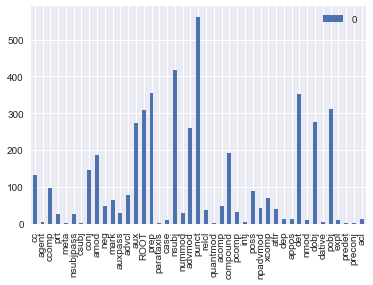

In [15]:
cntr = Counter(single_doc.dependency)
pd.DataFrame.from_dict(cntr, orient='index').plot(kind='bar')

## Next Steps

The next steps are the actual data exploration. There are key questions that need answering before we can formally embark on the data exploration, such as: what form should the output for each feature take, how do we get that output into our mixture models in R, etc. But take the time to play around with pandas and try and explore some of the features yourself!

In [16]:
keys = data.groupby(['subreddit']).groups.keys()

In [17]:
[k for k in keys if 'suicide' in k]

['suicidehelp',
 'Plumsuicide',
 'minecraftsuicidewatch',
 'suicide_watch',
 'suicidegirls',
 'suicideprevention',
 'suicide',
 'suicide_methods',
 'parasuicide',
 'suicidenotes']

In [18]:
# subreddits to filter
subreddits_to_filter = [
    'suicidehelp', 'suicide_watch', 'suicideprevention', 
    'suicide', 'suicide_methods', 'suicidenotes', 'depressed', 
    'depresion', 'antidepressants', 'depressionregimens'
]

In [19]:
controls, positives = data[data['user_id'] < 0]['time'], data[data['user_id'] > 0]['time']

# Distribution of Post Times

To analyze the distribution of post times, we can convert the post times to "seconds since midnight" (for the respective day) and plot a histogram.

In [20]:
def time_since_midnight(t):
    return (t.hour * 3600) + (t.minute * 60) + t.second + (t.microsecond / 1000000.0)
    
controls_seconds = controls.apply(lambda t: time_since_midnight(t.time()))
positives_seconds = positives.apply(lambda t: time_since_midnight(t.time()))

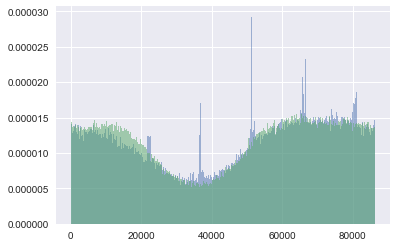

In [21]:
_ = plt.hist(controls_seconds, bins=1000, alpha=0.5, normed=True)
_ = plt.hist(positives_seconds, bins=1000, alpha=0.5, normed=True)

We can also use Kernel Density Estimation (from Seaborn, it's a pain to do from plain matplotlib/numpy) and plot a smoothed version of the histogram:

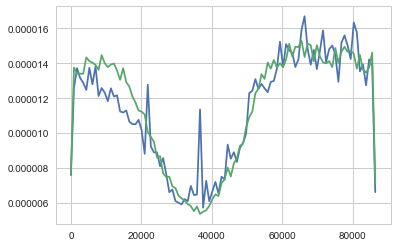

In [22]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(controls_seconds), bw=0.001)
sns.kdeplot(np.array(positives_seconds), bw=0.001)

# Getting Specific Indices/Sampling

In [23]:
training_data = load.select(load.sample_indices)
test_data = load.select(load.test_indices)

#sampled_data_with_features = load.select(load.sample_indices, df=load.documents)

In [24]:
load.finalize()